In [133]:
import numpy as np
import pandas as pd


%pylab inline

import seaborn as sns

import os

Populating the interactive namespace from numpy and matplotlib


/bigdata/sexism/sexist_code_icwsm20/icwsm20/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [155]:
finer_data = pd.read_csv("../data/all_data_annotations.csv", sep = '\t', index_col = False, encoding = 'utf-8')
data = pd.read_csv("../data/all_data.csv", sep = '\t', index_col = False, encoding = 'utf-8')
finer_data = finer_data.merge(data, on = ['_id', 'dataset'])
finer_orig = finer_data[finer_data['of_id'].isna()] # drop modifications
finer_mod = finer_data[~finer_data['of_id'].isna()] # only keep modifications

In [154]:
finer_orig.groupby(['dataset']).size()/5 # corresponds to 'w/ annot.' column in Table 3'

dataset
benevolent     678.0
callme        1280.0
hostile        678.0
other          678.0
scales         764.0
dtype: float64

In [156]:
finer_mod.groupby(['dataset']).size()/5 # corresponds to '#mod' column in Table 3'

dataset
benevolent     396.0
callme        1134.0
hostile        567.0
other           21.0
scales         125.0
dtype: float64

In [157]:
def encode_annotations(df):
    df['content_categorical'] = df.content.apply(lambda x: 'content_%d'%x)
    df['phrasing_categorical'] = df.phrasing.apply(lambda x: 'phrasing_%d'%x)

    df['content_merged_12_56'] = df.content.map({1:1, 2:1, 
                                                 3:3, 4:4, 
                                                 5:5, 6:5})
    df['content_merged_12_56_categorical'] = df.content_merged_12_56.apply(lambda x: 'content_%d'%x)


    df['content_merged_phrasing_categorical'] = df.content_merged_12_56_categorical+df.phrasing_categorical

    df['content_phrasing_categorical'] = df.content_categorical+df.phrasing_categorical

    df['content_binary'] = df.content.apply(lambda x: x<=4)
    df['phrasing_binary'] = df.phrasing.apply(lambda x: x==1)

    df['sexist_binary'] = df.content_binary | df.phrasing_binary
    df['sexist_factorial'] = df.content_binary.astype(str) + df.phrasing_binary.astype(str)
    
encode_annotations(finer_orig)

/bigdata/sexism/sexist_code_icwsm20/icwsm20/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/bigdata/sexism/sexist_code_icwsm20/icwsm20/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/bigdata/sexism/sexist_code_icwsm20/icwsm20/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

### Plot 1: Dataset Distribution

In [158]:
from collections import Counter 
def maj_vote(x,majority_at_least=3):
    most_common =  Counter(x).most_common(2)
    if len(most_common)<2: #perfect agreement
        return most_common[0][0]
    else: #some disagreement
        (k1, v1),(k2, v2) = most_common
        if (v1<majority_at_least) or (v2==v1): return np.nan
        else: return k1

def get_majority_df(df):
    df_majority = df.copy()

    df_majority=df_majority[[u'_id', 'dataset', 'text',
           u'content_categorical', u'phrasing_categorical',
           u'content_merged_12_56_categorical',
           u'content_binary', u'phrasing_binary', u'sexist_binary', #'sexist_factorial', 'content_merged_phrasing_categorical'
                            ]].groupby(['_id', 'dataset']).agg(maj_vote).reset_index()
    return df_majority

df_majority = get_majority_df(finer_orig)

In [159]:
df_majority['dataset'] = df_majority.dataset.map({"benevolent":"benevolent (b)", 'hostile':'hostile (h)','other':'other (o)', 'callme':'callme (c)','scales':'scales (s)'})

In [160]:
df_majority['plot_order'] = df_majority.dataset.apply(lambda x:{"benevolent (b)":0, 'hostile (h)':1,'other (o)':2, 'callme (c)':3,'scales (s)':4}[x])
#df_majority['plot_order'] = df_majority.dataset.apply(lambda x:dict(enumerate((df_majority.content_categorical.unique())))[x])

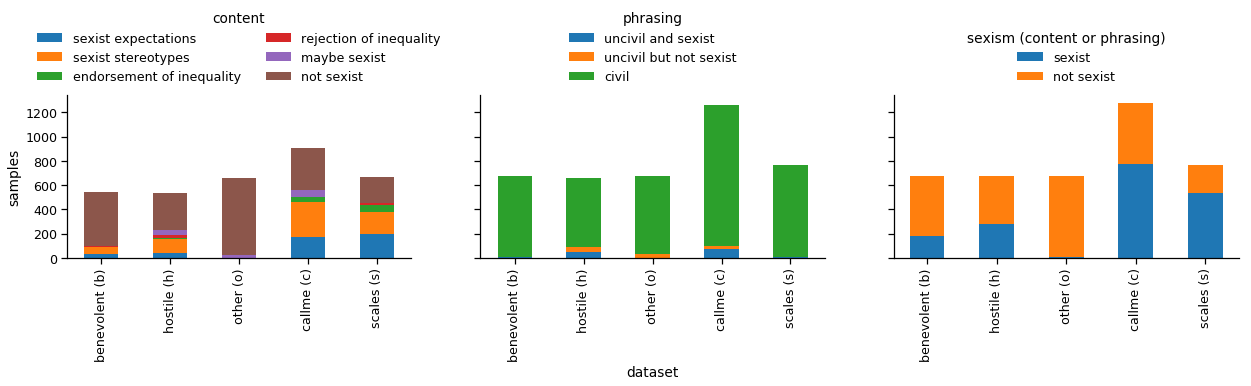

In [161]:
with sns.plotting_context('notebook', font_scale=1.15):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, False, True, figsize=(21, 3.))

    df_majority['plot_order'] = df_majority.dataset.apply(lambda x:{"benevolent (b)":0, 'hostile (h)':1,'other (o)':2, 'callme (c)':3,'scales (s)':4}[x])
    df_majority['plot_order'] += df_majority.content_categorical.apply(lambda x:dict((j, i) for i, j in enumerate((df_majority.content_categorical.unique())))[x])
    by_content = df_majority.sort_values('plot_order', ).groupby(['dataset', 'content_categorical'], sort=False)['dataset'].count().unstack('content_categorical').fillna(0)

    ax=by_content[sorted(by_content.columns)].plot(kind='bar', stacked=True,ax=ax1)
    sns.despine()
    # Put a legend below current axis
    _=ax.legend(['sexist expectations', 'sexist stereotypes', 
                           'endorsement of inequality', 'rejection of inequality', 
                           'maybe sexist', 'not sexist'], loc='lower center', bbox_to_anchor=(.5, 1.), ncol=2,
              fancybox=False, shadow=False, frameon=False, title='content')
    ax.set_xlabel('')
    ax.set_ylabel('samples', )


    df_majority['plot_order'] = df_majority.dataset.apply(lambda x:{"benevolent (b)":0, 'hostile (h)':10,'other (o)':20, 'callme (c)':30,'scales (s)':40}[x])
    df_majority['plot_order'] += df_majority.phrasing_categorical.apply(lambda x:dict((j, i) for i, j in enumerate((df_majority.phrasing_categorical.unique())))[x])
#     df_majority['plot_order'] += df_majority.phrasing_categorical.apply(lambda x:dict((j, i) for i, j in enumerate(sorted(df_majority.phrasing_categorical.unique())))[x])
    
    by_phrasing = df_majority.sort_values('plot_order', ).groupby(['dataset', 'phrasing_categorical'], sort=False)['dataset'].count().unstack('phrasing_categorical').fillna(0)

    ax=by_phrasing[sorted(by_phrasing.columns)].plot(kind='bar', stacked=True,ax=ax2)
    sns.despine()
    # Put a legend below current axis
    _=ax.legend(['uncivil and sexist', 'uncivil but not sexist', 'civil'],
                loc='lower center', bbox_to_anchor=(.5, 1.), ncol=1,
              fancybox=False, shadow=False, frameon=False, title="phrasing")

    
    
    by_sexism = df_majority.sort_values('plot_order', ).groupby(['dataset', 'sexist_binary'], sort=False)['dataset'].count().unstack('sexist_binary').fillna(0)
    by_sexism.columns=['not sexist', 'sexist', ]
    
    ax=by_sexism[['sexist','not sexist']].plot(kind='bar', stacked=True,ax=ax3)
    sns.despine()
    # Put a legend below current axis
    _=ax.legend(loc='lower center', bbox_to_anchor=(.5, 1.), ncol=1,
              fancybox=False, shadow=False, frameon=False, title="sexism (content or phrasing)")
    _=ax.set_xlabel('')
    plt.autoscale()

### Plot 2

In [163]:
import pickle

with open("../results/run_results_allothers_final2_refactor.pkl", 'rb') as f:
    results_df = pickle.load(f)

In [164]:
toplot=results_df.copy()

toplot = toplot.melt(id_vars=['train', 'test', 'train_domain'], value_vars = [u'macro avg f1-score',
u'sexist recall',
         u'sexist precision',])
toplot = toplot[toplot.train.isin(['original_logit', 'adversarial_logit', 
                                   'original_bert', 'adversarial_bert',
                                   u'adversarial_bert_finetuned',u'original_bert_finetuned',
                                   'original_cnn', 'adversarial_cnn',
                                   'original_thold','original_baseline', ])]

toplot = toplot[toplot.test.isin([
    'goldtrain_original',
    'omnibus_original', 'omnibus_adversarial', 
    'replication_original','replication_adversarial', 
    'reproduction_original','reproduction_adversarial'])]

toplot = toplot[toplot.train_domain.isin(['goldtrain', 'omnibus', 'replication', 'reproduction'])]


toplot['test'] =toplot.test.map(dict(zip(['reproduction_original', 'reproduction_adversarial', 
                             'replication_original', 'replication_adversarial', 
                             'goldtrain_original',
                            'omnibus_original', 'omnibus_adversarial', ],
                        ['bho', 'bho-M', 
                             'c', 'c-M', 
                             's',
                            'bhocs', 'bhocs-M', ])))

toplot['train'] = toplot.train.map(dict(zip(['original_logit', 'adversarial_logit', 
                                   'original_bert', 'adversarial_bert',
                                   u'adversarial_bert_finetuned',u'original_bert_finetuned',
                                   'original_cnn', 'adversarial_cnn',
                                   'original_thold','original_baseline', ], 
                                    ['logit', 'logit-M', 
                                   'bert', 'bert-M',
                                   u'bert finetuned-M',u'bert finetuned',
                                   'cnn', 'cnn-M',
                                   'toxicity','gender word', ])))

toplot['train_domain'] = toplot.train_domain.map(dict(zip([u'goldtrain', u'omnibus', u'replication', u'reproduction'], 
                                    [u's (scales)', u'bhocs (omnibus)', u'c (callme)', u'bho (Jha17)'])))

toplot = toplot[(toplot.train_domain!= 's (scales)') & (~toplot.train.isin(['bert', 'bert-M']))]

toplot.columns = [u'model', u'test', u'train_domain', u'variable', u'value']

toplot = toplot[toplot.variable == u'macro avg f1-score']

In [165]:
toplot['train_domain'] = toplot['train_domain'].apply(lambda x: x.split(' ')[0])
toplot['train_domain']  += toplot.model.str.endswith('-M').apply(lambda x: x and '-M' or '')

toplot['model'] = toplot.model.apply(lambda x: x.endswith('-M') and x[:-2] or x)

gender_bline = toplot[toplot['model'] == 'gender word'].value.mean()
toxicity_bline = toplot[toplot['model'] == 'toxicity'].value.mean()



toplot = toplot[~toplot.model.isin(['toxicity', 'gender word',])]

toplot['train_domain'] = toplot.train_domain.map(dict(zip([u'bhocs', u'bhocs-M', u'c', u'c-M', u'bho', u'bho-M'],
                                [u'bhocs', u'bhocs-M', u'c', u'c-M', u'bho', u'bho-M'])))

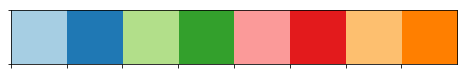

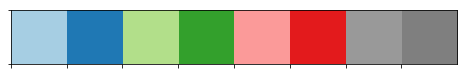

In [166]:
custom_palette = sns.color_palette("Paired",8)
sns.palplot(custom_palette)

custom_palette[-1] = (.5, .5, .5)
custom_palette[-2] = (.6, .6, .6)

sns.palplot(custom_palette)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

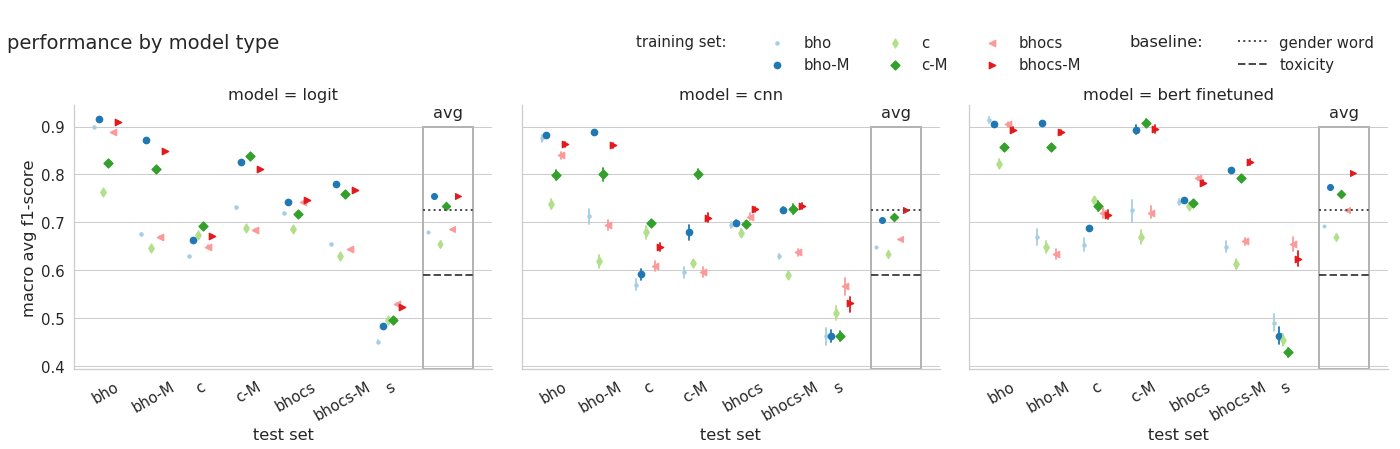

In [167]:
data_order = ['bho', 'bho-M', 
 'c', 'c-M', 
 'bhocs', 'bhocs-M', ]
model_order = ['logit', 'cnn', u'bert finetuned',]
marker_order = ['.','o', "d","D",  "<",">",]
with plt.rc_context(dict(sns.axes_style("whitegrid"),
                         **sns.plotting_context("notebook", font_scale=1.35, 
                                                rc={"lines.linewidth": 1.,}
                                               ))):
    g = sns.catplot(x='test', y='value', col='model', hue='train_domain',  
                    data=toplot, kind='point',
                    sharex=True, sharey=True,
                    col_order = model_order,
                    hue_order = data_order,
                    order = data_order+['s'],
                    markers=marker_order,
                    legend=False,
                    legend_out=True,
                
                    palette=custom_palette,
                    dodge=.5,
                    join=False,
                    aspect=1.3
                   )
    g.set_xlabels("test set")
    for ax in g.axes[0]: 
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
        plt.setp(ax.collections, sizes=[40])

    g.axes[0, 0].set_ylabel(u'macro avg f1-score')

    g.fig.suptitle('performance by model type', x=0, ha='left', y=1.1)
    l=g.axes[0, 2].legend(loc='upper right', bbox_to_anchor=(0.3, 1.4), ncol=3,
              fancybox=False, shadow=False, frameon=False)
    l.set_title('training set:')
    l.get_title().set_position((-240, -22))
    plt.setp(l.get_title(),fontsize=l.prop.get_size())

    clrs = dict(zip(data_order,
                   custom_palette, ))
    mrkrs = dict(zip(data_order,marker_order ))    
    pltn = {j: i for i, j in enumerate(model_order)}
    mdln = {j:i for i, j in enumerate(data_order)}
    import matplotlib.patches as patches
    for a, d in toplot.groupby(["train_domain","model"]).mean().reset_index().groupby("model"):
        for mdl, v in d.set_index('train_domain').value.to_dict().items():
            g.axes[0, pltn[a]].scatter([6.8+(mdln[mdl]/8.)], [d.set_index('train_domain').value.to_dict()[mdl]],
                                          c=clrs[mdl], marker=mrkrs[mdl], clip_on=True)
    for i in range(3):
        l1 = g.axes[0, i].plot((6.7, 7.75), 
                                    (gender_bline, gender_bline),
                                    ls=':', lw=2, c='.3', clip_on = True, #dashes=(1, 1+mdln[mdl]/3.)
                                      )  

        l2 = g.axes[0, i].plot((6.7, 7.75), 
                                    (toxicity_bline, toxicity_bline),
                                    ls='--', lw=2, c='.3', clip_on = True, #dashes=(1, 1+mdln[mdl]/3.)
                                      )  

    for i in range(3):
        g.axes[0, i].add_patch( patches.Rectangle((6.7,g.axes[0, pltn[a]].get_ylim()[0]),
                                                        1.05,.9-g.axes[0, pltn[a]].get_ylim()[0],
                                                        linewidth=2,
                                                        edgecolor='.7',
                                                        facecolor='none',
                                                        clip_on=False))
        g.axes[0, i].text(6.7+1.05/2, .92, 'avg', ha='center')
        
    from matplotlib.lines import Line2D

    lss = [':', '--']
    lines = [Line2D([0], [0], color='.3', linewidth=2, linestyle=ll) for ll in lss]
    labels = ['gender word', 'toxicity',]
    ll=g.axes[0, i].legend(lines, labels, loc='upper right', bbox_to_anchor=(1., 1.4), ncol=1,
              fancybox=False, shadow=False, frameon=False)
    ll.set_title('baseline:')
    ll.get_title().set_position((-140, -22))
    plt.setp(l.get_title(),fontsize=l.prop.get_size())
    g.axes[0, i].add_artist(l)
